In [1]:
import Pkg; Pkg.activate(".."); Pkg.instantiate();

  Activating project at `c:\Users\matti\Documents\TUe\Thesis\ThesisParallelMP`


In [2]:
using RxInfer, Random, StatsPlots, LinearAlgebra, ProgressMeter

In [3]:
@show Threads.nthreads(), Threads.nthreads(:interactive)

(Threads.nthreads(), Threads.nthreads(:interactive)) = (8, 0)


(8, 0)

In [4]:
includet("../parallel.jl")

In [5]:
n = 200  # Number of coin flips
p = 0.75 # Bias of a coin

distribution = Bernoulli(p)
dataset      = float.(rand(Bernoulli(p), n))
prior = Beta(2.0, 6.0)

Beta{Float64}(α=2.0, β=6.0)

In [6]:
@model function coin_model(n, prior, prod_strategy, pipeline, meta, prod_constraint)

    y = datavar(Float64, n)
	θ = randomvar() where { prod_strategy = prod_strategy, prod_constraint = prod_constraint }

    θ ~ prior

    for i in 1:n
        y[i] ~ Bernoulli(θ) where { pipeline = pipeline, meta = meta  }
    end

end

In [7]:
struct MyCustomRule
	size::Int
end

function factorial(n)
    if n == 0 || n == 1
        return 1
    else
        return factorial(n - 1) + factorial(n - 2)
    end
end

@rule Bernoulli(:p, Marginalisation) (q_out::PointMass, meta::MyCustomRule) = begin
    @logscale -log(2)
    r = mean(q_out)
    s = factorial(meta.size) / 10^8
    return Beta(one(r) + r, 2one(r) - r + s)
end

In [21]:
function RxInfer.BayesBase.prod(custom::MyCustomProd, left, right)
    r = mean(left)
	s = factorial(custom.size) / 10^8
    return prod(GenericProd(), Beta(one(r) + r, 2one(r) - r + s), right)
end

function RxInfer.BayesBase.prod(custom::MyCustomProd, left::Missing, right)
    return right
end

In [9]:
function execute_benchmark(f::F, n = 1000) where { F }

    # For the compilation
    f()

    GC.gc()
    GC.gc(true)

    times = Vector{Float64}(undef, n)

    for i in 1:n
        times[i] = f()
    end

    return times
end

execute_benchmark (generic function with 2 methods)

In [10]:
function benchmark_rule(meta; n = 1000)
    times = Vector{Float64}(undef, n)

    for i in 1:n
        start_time = time_ns()
        @call_rule Bernoulli(:p, Marginalisation) (q_out = PointMass(1), meta = meta)
        times[i] = time_ns() - start_time
    end

    return times / 1000
end

benchmark_rule (generic function with 1 method)

In [11]:
function prepare_benchmark(prod, pipeline, dataset, prior, meta, prod_constraint, niterations = 100)
    return () -> begin
        timing = Ref(0.0)
        current_iter = Ref(0.0)
        infer(
            model = coin_model(length(dataset), prior, prod, pipeline, meta, prod_constraint),
            data  = (y = dataset, ),
            callbacks = (
                before_iteration = (model, iteration) -> begin
                    current_iter[] = time_ns()
                    return false
                end,
                after_iteration = (model, iteration) -> begin
                    current_iter[] = time_ns() - current_iter[]
                    timing[] = timing[] + current_iter[]
                    return false
                end
            ),
            iterations = niterations
        )
        return timing[]
    end
end

prepare_benchmark (generic function with 2 methods)

In [12]:
function run_rule_benchmark(combinations, sizes; nsamples = 10, dataset = dataset, prior = prior, niterations = 100)
    return @showprogress map(sizes) do size

        results = Dict()
        results[:rule] = benchmark_rule(MyCustomRule(size))

        for (key, combination) in combinations
            _b_combination = prepare_benchmark(combination[1], combination[2], dataset, prior, MyCustomRule(size), nothing, niterations)
            results[key] = execute_benchmark(_b_combination, nsamples)
        end

        return (size, results)
    end
end

run_rule_benchmark (generic function with 1 method)

In [13]:
combinations = [
    :sequential => (nothing, nothing),
    :parallel_fifo_prod => (CustomProdStrategy(fifo_prod), nothing),
    :parallel_pipeline => (nothing, ThreadsPipelineStage()),
    :parallel_fifo_pipeline => (CustomProdStrategy(fifo_prod), ThreadsPipelineStage()),
    :parallel_frfo_pipeline => (CustomProdStrategy(frfo_prod), ThreadsPipelineStage()),
]

5-element Vector{Pair{Symbol, Tuple{Any, Any}}}:
             :sequential => (nothing, nothing)
     :parallel_fifo_prod => (CustomProdStrategy{typeof(fifo_prod)}(fifo_prod), nothing)
      :parallel_pipeline => (nothing, ThreadsPipelineStage())
 :parallel_fifo_pipeline => (CustomProdStrategy{typeof(fifo_prod)}(fifo_prod), ThreadsPipelineStage())
 :parallel_frfo_pipeline => (CustomProdStrategy{typeof(frfo_prod)}(frfo_prod), ThreadsPipelineStage())

In [14]:
function plot_rule_benchmark(combinations, sizes, n, niterations)
    rule_results = run_rule_benchmark(combinations, sizes; dataset=float.(rand(distribution, n)), niterations = niterations);

    sizes = getindex.(rule_results, 1)
    benchmarks = getindex.(rule_results, 2)
    names = [first.(combinations); :rule]

    points = map(names) do name
        name => minimum.(getindex.(benchmarks, name))
    end |> Dict

    p = plot(
        xaxis = :log,
        yaxis = :log,
        legend = :bottomright,
        xlabel = "Rule time [μs]",
        ylabel = "Relative speed [-]",
        yticks = ([1:8;], [string(a) for a in 1:8]),
        ylim = (0.3, 8),
        gridalpha = 0.3,
        title = "N = $n",
    )

    for (key, values) in pairs(points)
        if key != :rule
            plot!(p, points[:rule], points[:sequential] ./ values, label = string(key))
        end
    end

    return p
end

plot_rule_benchmark (generic function with 1 method)

In [15]:
sizes = 10:2:25
niterations = 100

p1 = plot_rule_benchmark(combinations, sizes, 50, niterations)
p2 = plot_rule_benchmark(combinations, sizes, 100, niterations)
p3 = plot_rule_benchmark(combinations, sizes, 200, niterations);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:58
Progress: 100%|█████████████████████████████████████████| Time: 0:01:33
Progress: 100%|█████████████████████████████████████████| Time: 0:02:53


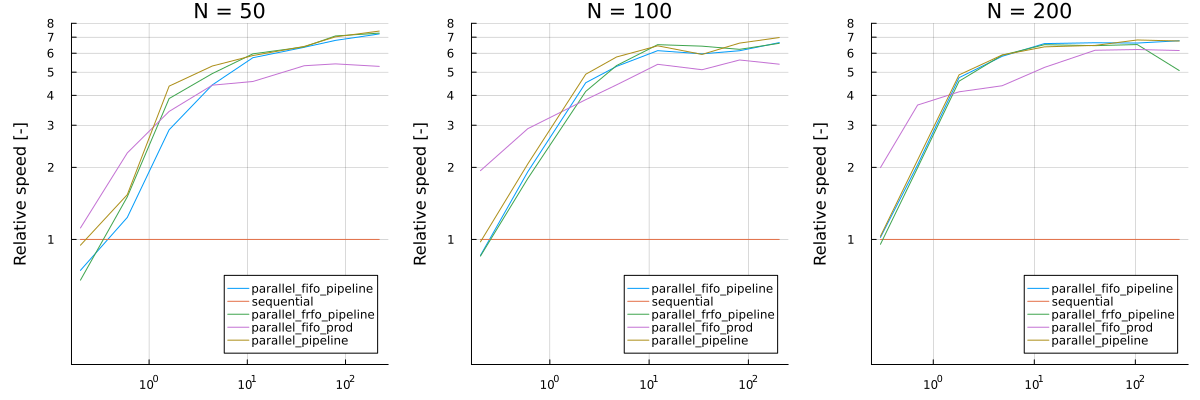

In [16]:
plot(p1, p2, p3, layout = (1, 3), size = (1200, 400), left_margin = 8Plots.mm)

In [17]:
function benchmark_prod(size; n = 1000)
    times = Vector{Float64}(undef, n)

    left = Beta(1, 1)
    right = Beta(1, 1)

    for i in 1:n
        start_time = time_ns()
        r = mean(left)
        s = factorial(size) / 10^8
        prod(GenericProd(), Beta(one(r) + r, 2one(r) - r + s), right)
        times[i] = time_ns() - start_time
    end

    return times / 1000
end

benchmark_prod (generic function with 1 method)

In [18]:
function run_prod_benchmark(combinations, sizes; nsamples = 10, dataset = dataset, prior = prior, niterations = 100)
    return @showprogress map(sizes) do size

        results = Dict()
        results[:prod] = benchmark_prod(size)

        for (key, combination) in combinations
            _b_combination = prepare_benchmark(combination[1], combination[2], dataset, prior, nothing, MyCustomProd(size), niterations)
            results[key] = execute_benchmark(_b_combination, nsamples)
        end

        return (size, results)
    end
end

run_prod_benchmark (generic function with 1 method)

In [19]:
function plot_prod_benchmark(combinations, sizes, n, niterations)
    rule_results = run_prod_benchmark(combinations, sizes; dataset=float.(rand(distribution, n)), niterations = niterations);

    sizes = getindex.(rule_results, 1)
    benchmarks = getindex.(rule_results, 2)
    names = [first.(combinations); :prod]

    points = map(names) do name
        name => minimum.(getindex.(benchmarks, name))
    end |> Dict

    p = plot(
        xaxis = :log,
        yaxis = :log,
        legend = :bottomright,
        xlabel = "Product time [μs]",
        ylabel = "Relative speed [-]",
        yticks = ([1:8;], [string(a) for a in 1:8]),
        ylim = (0.3, 8),
        gridalpha = 0.3,
        title = "N = $n",
    )

    for (key, values) in pairs(points)
        if key != :prod
            plot!(p, points[:prod], points[:sequential] ./ values, label = string(key))
        end
    end

    return p
end

plot_prod_benchmark (generic function with 1 method)

In [24]:
sizes = 10:2:20
niterations = 100

p1 = plot_prod_benchmark(combinations, sizes, 50, niterations)
p2 = plot_prod_benchmark(combinations, sizes, 500, niterations)
p3 = plot_prod_benchmark(combinations, sizes, 2000, niterations);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:20
Progress: 100%|█████████████████████████████████████████| Time: 0:01:45
Progress: 100%|█████████████████████████████████████████| Time: 0:06:37


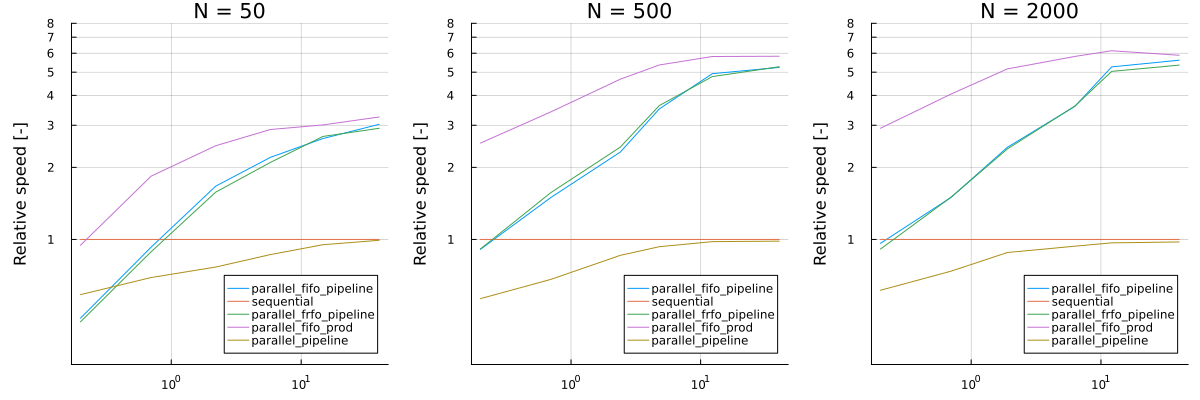

In [25]:
plot(p1, p2, p3, layout = (1, 3), size = (1200, 400), left_margin = 8Plots.mm)